In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import GRU, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, ELU, ReLU, Reshape, Input,RepeatVector
from tensorflow.keras import Sequential, regularizers
from tensorflow.python.client import device_lib
import sys
!{sys.executable} -m pip install hdf5storage
import hdf5storage
from os import path
from tensorflow.keras import layers, initializers
from sklearn.preprocessing import StandardScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.4 MB/s eta 0:00:00


# Data Preprocess

In [ ]:
LOB_input = hdf5storage.loadmat('S092215-v50-AMZN_OCT2_states.mat')
df = pd.DataFrame.from_dict(LOB_input['LOB'])
df.columns = [
                      "Time", "Mid_Price", "Spread",
                      "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1", # Level 1
                      "AskPrice2", "AskVolume2","BidPrice2", "BidVolume2", # Level 2
                      "AskPrice3", "AskVolume3","BidPrice3", "BidVolume3", # Level 3
                      "AskPrice4", "AskVolume4","BidPrice4", "BidVolume4", # Level 4
                      "AskPrice5", "AskVolume5","BidPrice5", "BidVolume5", # Level 5
                      "AskPrice6", "AskVolume6","BidPrice6", "BidVolume6", # Level 6
                      "AskPrice7", "AskVolume7","BidPrice7", "BidVolume7", # Level 7
                      "AskPrice8", "AskVolume8","BidPrice8", "BidVolume8", # Level 8
                      "AskPrice9", "AskVolume9","BidPrice9", "BidVolume9", # Level 9
                      "AskPrice10", "AskVolume10","BidPrice10", "BidVolume10" # Level 10
                     ]

In [ ]:
lob_data=df.iloc[10:100010, [0, 1, 3, 4, 5, 6]]
lob_data['Time_int'] = df['Time'].diff()
lob_data=lob_data.iloc[:, 1:]
lob_data = lob_data[[lob_data.columns[-1]] + list(lob_data.columns[:-1])]
df=lob_data.copy()

In [ ]:
cols_price =['AskPrice1', 'BidPrice1','Mid_Price']
# Define the normalization range (0 to 2)
min_value = 0
max_value = 1

# Calculate the scaling factors
min_val = 0
max_val = 5507700

scaling_factor = (max_value - min_value) / (max_val - min_val)

def feature_scale(column):
    scaled = min_value + (column - min_value) * scaling_factor
    return scaled

# Apply feature scaling to the selected columns
df[cols_price] = df[cols_price].apply(feature_scale)

#-----------------------------------------------------------
cols_vol =['AskVolume1', 'BidVolume1']
# Define the normalization range (0 to 2)
min_value1 = 0
max_value1 = 1

# Calculate the scaling factors
min_val1 = 0
max_val1 = 1250

scaling_factor1 = (max_value1 - min_value1) / (max_val1 - min_val1)

def feature_scale1(column):
    scaled = min_value1 + (column - min_value1) * scaling_factor1
    return scaled

# Apply feature scaling to the selected columns
df[cols_vol] = df[cols_vol].apply(feature_scale1)
#---------------------
cols_to_feature_scale = ['Time_int']

# Custom scaling range for the feature scaling
custom_min = 0
custom_max = 1

# Calculate the minimum and maximum values for each column
min_values = 0
max_values =  169619

# Feature scaling function
def feature_scale(column):
    scaled = custom_min + (column - min_values) * (custom_max - custom_min) / (max_values - min_values)
    return scaled

# Apply feature scaling to the selected columns
df[cols_to_feature_scale] = df[cols_to_feature_scale].apply(feature_scale)
lob=df.copy()

# Training Process

In [ ]:
def make_rnn(n_layers, hidden_units, output_units, name):
    x = Input(shape=(None, hidden_units))
    h = x
    for _ in range(n_layers):
        h = GRU(units=hidden_units, return_sequences=True)(h)
    y = Dense(units=output_units, activation='tanh', name=name)(h)
    return Model(inputs=x, outputs=y, name=name)

def build_generator(latent_dim, window_size, num_features, gru_units):
    hidden_dim = 5
    # Input for noise
    input_noise = Input(shape=(latent_dim,))

    # Repeat the noise vector to match the length of the time series data
    repeated_noise = RepeatVector(window_size)(input_noise)

    # First GRU layer to learn sequential patterns
    gru_layer1 = GRU(units=gru_units, return_sequences=True)(repeated_noise)

    # Second GRU layer to learn further sequential patterns
    gru_layer2 = GRU(units=gru_units, return_sequences=True)(gru_layer1)

    # Output layer to generate synthetic time series data
    output_data = Dense(units=num_features, activation='sigmoid')(gru_layer2)

    # Reshape the output_data to match the input shape of the Embedder
    reshaped_output_data = Reshape((window_size, num_features))(output_data)

    # Define the Embedder and Recovery components
    embedder = make_rnn(n_layers=3, hidden_units=num_features, output_units=hidden_dim, name='Embedder')
    recovery = make_rnn(n_layers=3, hidden_units=hidden_dim, output_units=num_features, name='Recovery')

    # Connect the Embedder, generator, and Recovery
    embedded_data = embedder(reshaped_output_data)
    recovered_data = recovery(embedded_data)

    generator = Model(inputs=input_noise, outputs=recovered_data)
    return generator

# Define the discriminator
def build_discriminator(window_size, num_features, num_units):
    input_data = Input(shape=(window_size, num_features))

    x = GRU(units=num_units, return_sequences=True)(input_data)
    x = LeakyReLU(alpha=0.2)(x)

    # x = GRU(units=num_units*2, return_sequences=True)(x)
    # x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(units=1, activation='sigmoid')(x)

    discriminator = Model(inputs=input_data, outputs=x)
    return discriminator

# Define the generator loss function
def generator_loss(fake_output, fake_features, target_features):
    # Wasserstein GAN loss
    wgan_loss = -tf.reduce_mean(fake_output)
    return wgan_loss

# Define the discriminator loss function
def discriminator_loss(real_output, fake_output):
    # Wasserstein GAN loss
    wgan_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
    return wgan_loss

# Create a function to generate new data using the trained generator
def generate_new_data(generator, latent_dim, num_samples):
    noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
    generated_data = generator.predict(noise)
    return generated_data

# Function to calculate gradient penalty
def gradient_penalty(discriminator, real_samples, generated_samples,labmda):
    # Randomly sample points between real and generated data
    alpha = tf.random.uniform(shape=[real_samples.shape[0], 1, 1], minval=0.0, maxval=1.0)
    interpolates = alpha * real_samples + (1 - alpha) * generated_samples

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolates)
        disc_interpolates = discriminator(interpolates)

    # Calculate gradients of the discriminator with respect to the interpolated points
    gradients = gp_tape.gradient(disc_interpolates, interpolates)
    gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2]))
    gradient_penalty = labmda*tf.reduce_mean((gradients_norm - 1) ** 2)

    return gradient_penalty

# Example usage
if __name__ == "__main__":
    # Set hyperparameters
    latent_dim = 100
    window_size = 1
    num_features = 6
    gru_units = 64
    num_filters = 128
    labmda = 10

    # Build the generator and discriminator
    generator = build_generator(latent_dim, window_size, num_features, gru_units)
    discriminator = build_discriminator(window_size, num_features, num_filters)

    # Compile the models
    generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
                      loss=generator_loss)
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
                          loss=discriminator_loss)

    # Combine the generator and discriminator to create the GAN
    z = Input(shape=(latent_dim,))
    generated_data = generator(z)
    validity = discriminator(generated_data)

    gan = Model(z, validity)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
                loss=generator_loss)

    # Load and preprocess your original dataset (lob_10)
    # Replace the following line with your own data loading and preprocessing code
    original_data = np.random.random(size=(1000, window_size, num_features))


epochs = 5000
batch_size = 128
clip_value = 0.1
n_critic = 5  # Number of times to train the critic per generator iteration

# Load and preprocess your original dataset (lob_10)
# Replace the following line with your own data loading and preprocessing code
# original_data = np.random.random(size=(1000, window_size, num_features))

# Define optimizers for generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)


#-------------------------------------------------------------------------------------------

disc_losses = []
gen_losses = []
# Training loop
for epoch in range(epochs):
    for _ in range(n_critic):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real data
        idx = np.random.randint(0, original_data.shape[0], batch_size)
        real_samples = original_data[idx]

        # Generate a batch of noise samples
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))

        with tf.GradientTape() as disc_tape:
            # Generate a batch of fake data
            generated_data = generator(noise)

            # Compute discriminator outputs for real and fake data
            real_output = discriminator(real_samples)
            fake_output = discriminator(generated_data)

            # Compute Wasserstein GAN loss for the discriminator
            disc_loss = discriminator_loss(real_output, fake_output)

            # Compute gradient penalty
            gp = gradient_penalty(discriminator, real_samples, generated_data, labmda)

            # Add gradient penalty to the discriminator loss
            disc_loss += gp

        # Get gradients of the discriminator loss with respect to the discriminator's parameters
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Apply gradient clipping to prevent gradient explosion
        clipped_gradients = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in gradients_of_discriminator]

        # Update the discriminator's parameters using the optimizer
        discriminator_optimizer.apply_gradients(zip(clipped_gradients, discriminator.trainable_variables))

    # ---------------------
    #  Train Generator
    # ---------------------

    # Generate a batch of noise samples
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))



    intermediate_layer_model = Model(inputs=discriminator.input,
                                 outputs=discriminator.layers[-2].output)
    def get_discriminator_features(data):
        return intermediate_layer_model(data)


    with tf.GradientTape() as gen_tape:
        # Generate a batch of fake data
        generated_data = generator(noise)

        # Compute discriminator outputs for the generated data
        fake_output = discriminator(generated_data)

        # Compute feature matching loss
        target_features = get_discriminator_features(real_samples)
        fake_features=get_discriminator_features(generated_data).numpy()
        gen_loss = generator_loss(fake_output, fake_features, target_features)

#     # Get gradients of the generator loss with respect to the generator's parameters
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)


    #record the loss
    disc_losses.append(disc_loss.numpy())
    gen_losses.append(gen_loss.numpy())


    # Update the generator's parameters using the optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


    # Print the progress
    print(f"Epoch {epoch}/{epochs} [D loss: {disc_loss}] [G loss: {gen_loss}]")

    # Optionally, save generated data during training
    if epoch % 100 == 0:
        generated_data = generate_new_data(generator, latent_dim, num_samples=100)
        # Save or visualize generated_data here

Streaming output truncated to the last 5000 lines.
Epoch 49/5000 [D loss: 1.1542892456054688] [G loss: -0.4578491747379303]
Epoch 50/5000 [D loss: 1.1110026836395264] [G loss: -0.46019691228866577]
Epoch 51/5000 [D loss: 0.9687222838401794] [G loss: -0.464821457862854]
Epoch 52/5000 [D loss: 1.0072236061096191] [G loss: -0.46815574169158936]
Epoch 53/5000 [D loss: 1.016593098640442] [G loss: -0.47349435091018677]
Epoch 54/5000 [D loss: 0.9458041787147522] [G loss: -0.47713688015937805]
Epoch 55/5000 [D loss: 0.8275919556617737] [G loss: -0.4806447923183441]
Epoch 56/5000 [D loss: 0.777606189250946] [G loss: -0.4858931303024292]
Epoch 57/5000 [D loss: 0.8668206334114075] [G loss: -0.4893314838409424]
Epoch 58/5000 [D loss: 0.8127626180648804] [G loss: -0.4929429292678833]
Epoch 59/5000 [D loss: 0.6961473822593689] [G loss: -0.4967024326324463]
Epoch 60/5000 [D loss: 0.7464140057563782] [G loss: -0.5015714168548584]
Epoch 61/5000 [D loss: 0.6229474544525146] [G loss: -0.5055122375488281]

# Generate data

In [ ]:
# Sample random noise
num_samples_to_generate = 99999
noise = tf.random.normal([num_samples_to_generate, latent_dim])

# Generate samples
generated_samples = generator(noise, training=False)

NameError: ignored

In [ ]:
generated_samples.shape

TensorShape([99999, 1, 6])

In [ ]:
# Drop dimension-1 (size 10) from the tensor using tf.reshape
fake = tf.reshape(generated_samples, shape=(-1, num_features))
real = tf.reshape(df, shape=(-1, num_features))
print(fake.shape)

(99999, 6)


In [ ]:
fake_sel = fake[fake[:, 2] > fake[:, 4]]
real_sel= real[real[:, 2] > real[:, 4]]
real_sel=real_sel[:len(fake_sel)]

# Visualization


## Mid-price

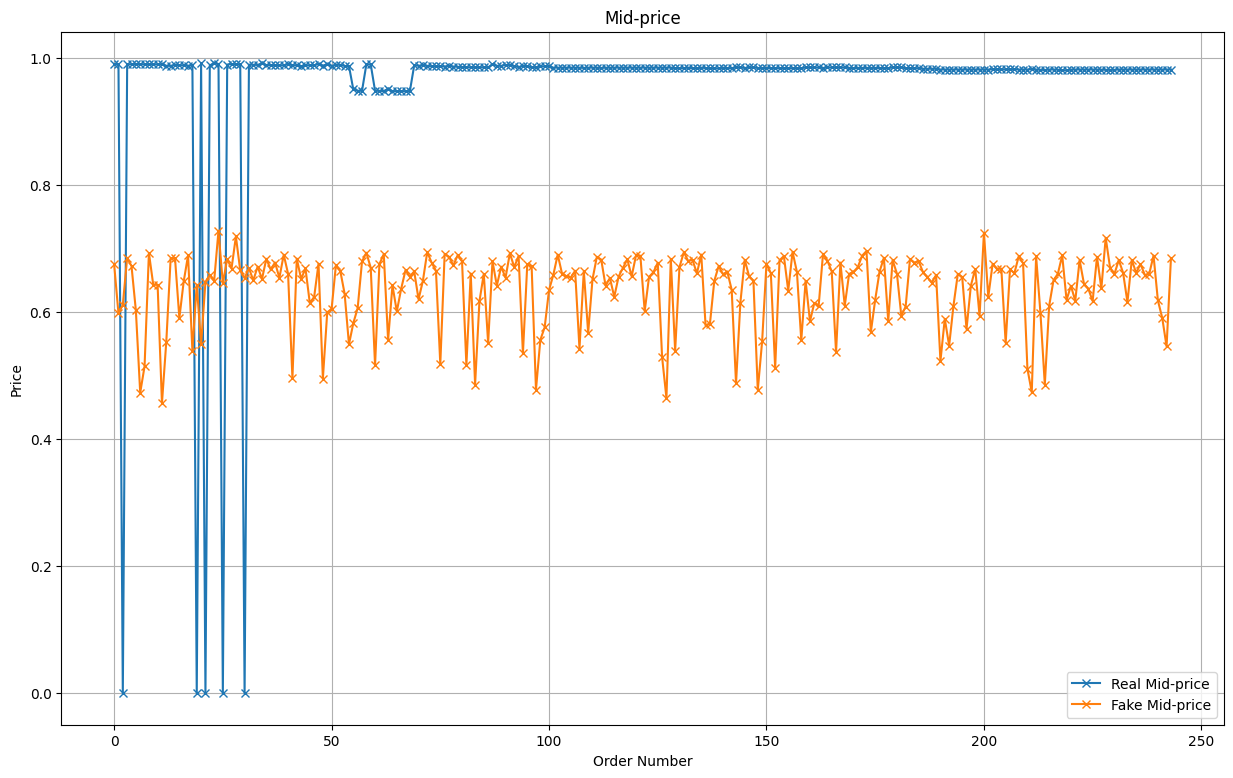

In [ ]:
plt.figure(figsize=(15, 9))


# Create the plot
plt.plot(real_sel[::300,1], marker='x', linestyle='-' ,label='Real Mid-price')
plt.plot(fake_sel[::300,1], marker='x', linestyle='-', label='Fake Mid-price')
# plt.plot(plot_f.iloc[:,4], marker='x', linestyle='--', label='Fake Bids')
# plt.plot(plot_f.iloc[:,2], plot_f.iloc[:,1], marker='x', linestyle='--', label='Fake Asks')

# Add labels and title
plt.xlabel('Order Number')
plt.ylabel('Price')
plt.title('Mid-price')

# Add a legend to distinguish the lines
plt.legend()

# # Adjust the aspect ratio (width / height) as desired
# plt.gca().set_aspect(1.5)  # Increase the number to make x-axis wider, decrease to make y-axis taller

# Display the plot
plt.grid(True)
plt.show()

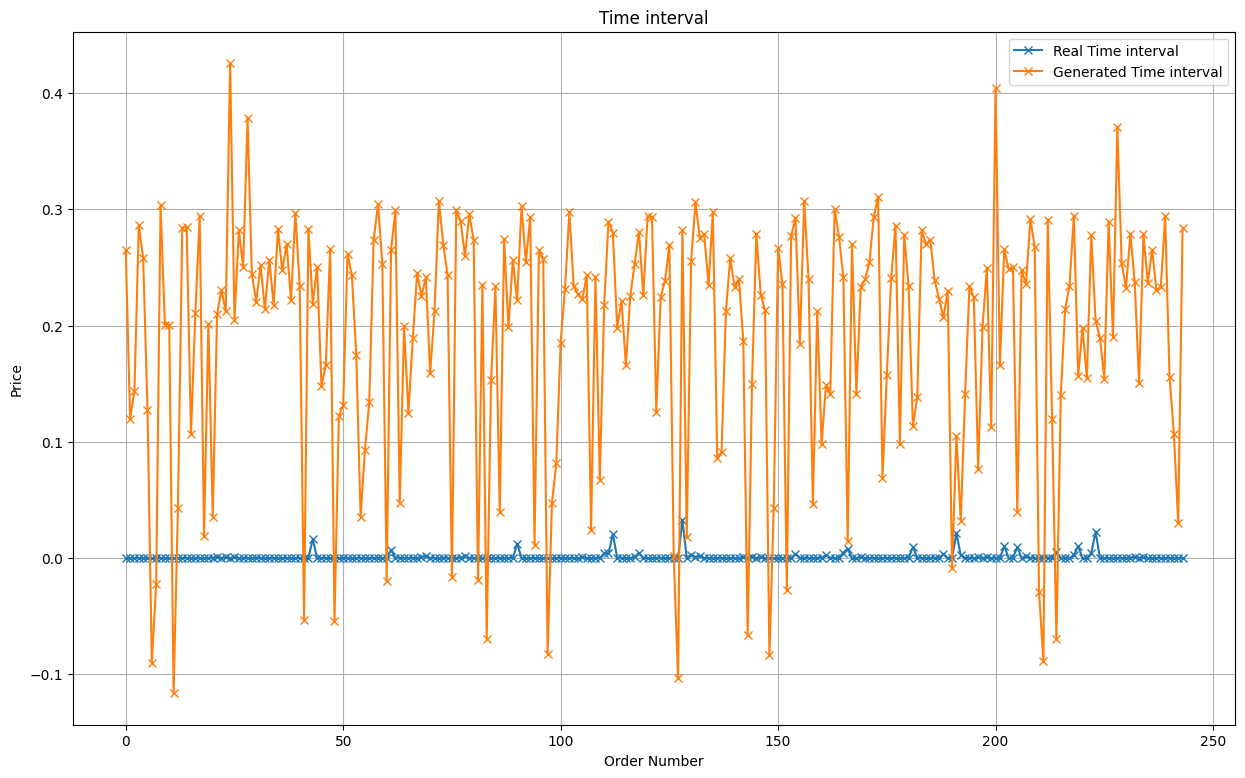

In [ ]:
plt.figure(figsize=(15, 9))


# Create the plot
plt.plot(real_sel[::300,0], marker='x', linestyle='-' ,label='Real Time interval')
plt.plot(fake_sel[::300,0], marker='x', linestyle='-', label='Generated Time interval')
# plt.plot(plot_f.iloc[:,4], marker='x', linestyle='--', label='Fake Bids')
# plt.plot(plot_f.iloc[:,2], plot_f.iloc[:,1], marker='x', linestyle='--', label='Fake Asks')

# Add labels and title
plt.xlabel('Order Number')
plt.ylabel('Price')
plt.title('Time interval')

# Add a legend to distinguish the lines
plt.legend()

# # Adjust the aspect ratio (width / height) as desired
# plt.gca().set_aspect(1.5)  # Increase the number to make x-axis wider, decrease to make y-axis taller

# Display the plot
plt.grid(True)
plt.show()

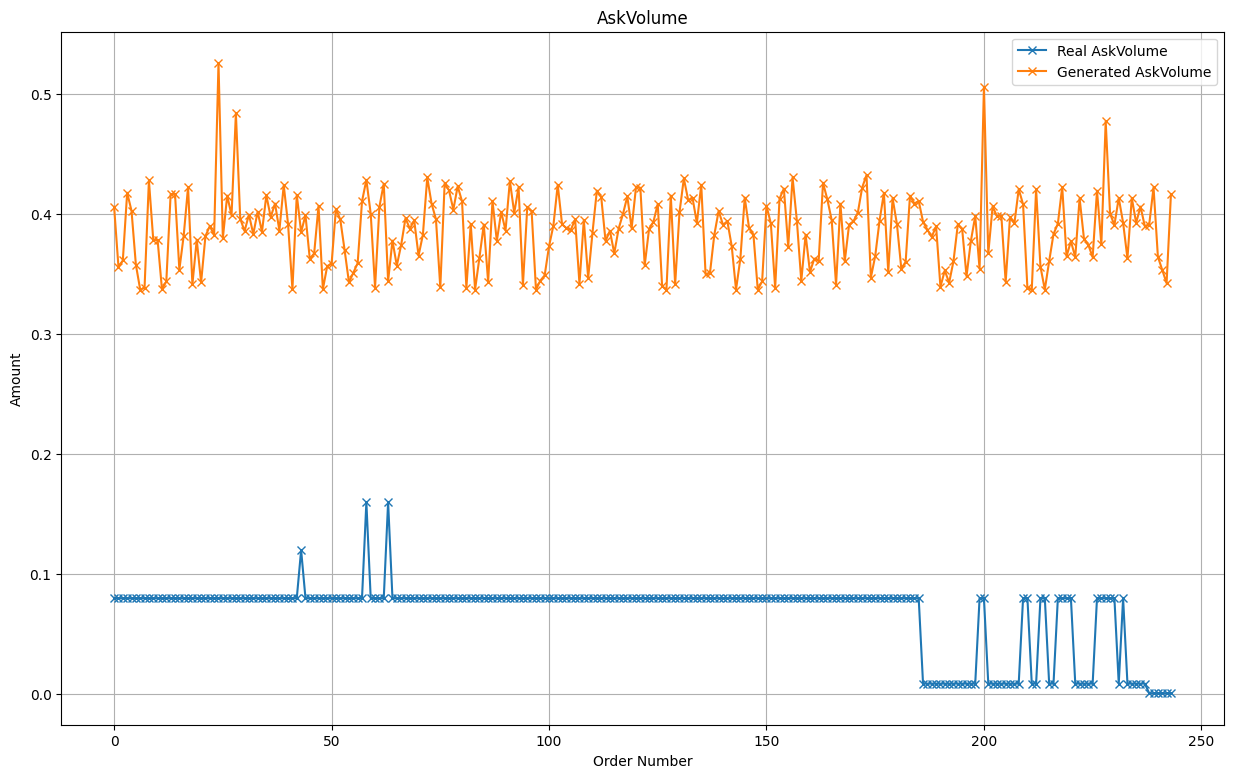

In [ ]:
plt.figure(figsize=(15, 9))


# Create the plot
plt.plot(real_sel[::300,3], marker='x', linestyle='-' ,label='Real AskVolume')
plt.plot(fake_sel[::300,3], marker='x', linestyle='-', label='Generated AskVolume')
# plt.plot(plot_f.iloc[:,4], marker='x', linestyle='--', label='Fake Bids')
# plt.plot(plot_f.iloc[:,2], plot_f.iloc[:,1], marker='x', linestyle='--', label='Fake Asks')

# Add labels and title
plt.xlabel('Order Number')
plt.ylabel('Amount')
plt.title('AskVolume')

# Add a legend to distinguish the lines
plt.legend()

# # Adjust the aspect ratio (width / height) as desired
# plt.gca().set_aspect(1.5)  # Increase the number to make x-axis wider, decrease to make y-axis taller

# Display the plot
plt.grid(True)
plt.show()

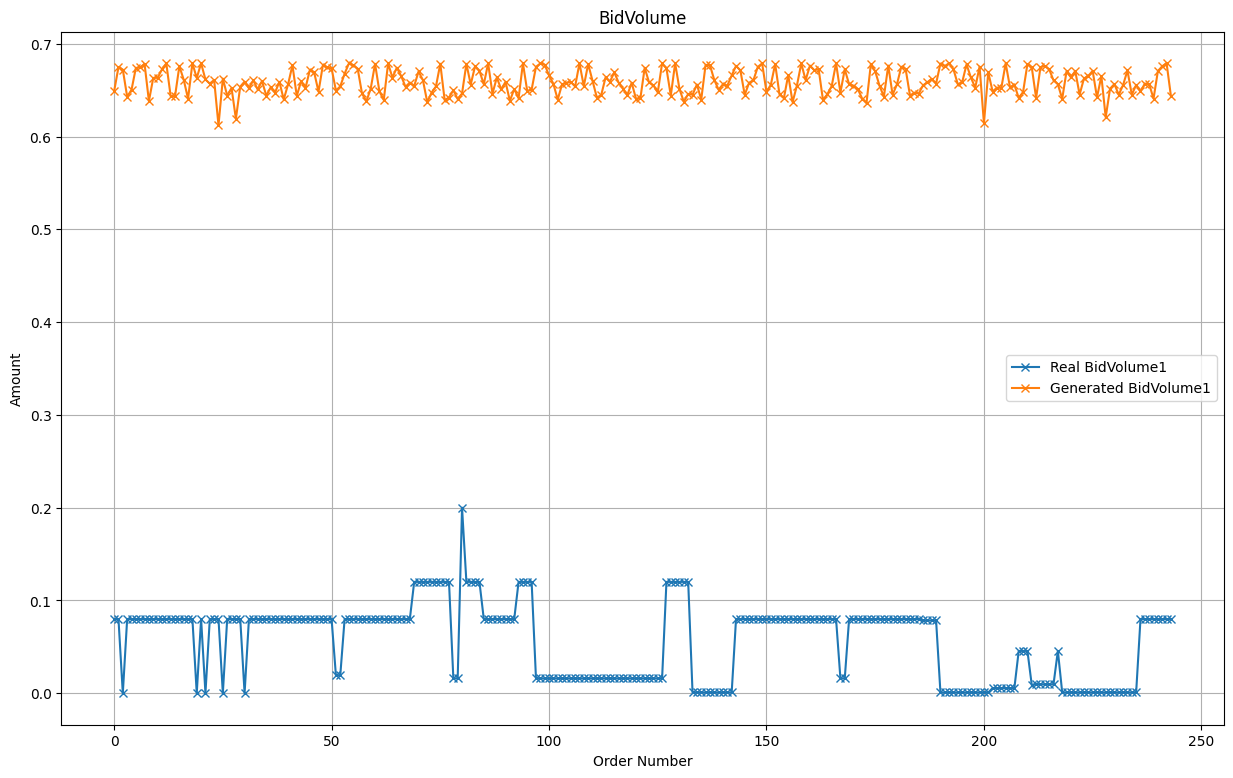

In [ ]:
plt.figure(figsize=(15, 9))


# Create the plot
plt.plot(real_sel[::300,5], marker='x', linestyle='-' ,label='Real BidVolume1')
plt.plot(fake_sel[::300,5], marker='x', linestyle='-', label='Generated BidVolume1')


# Add labels and title
plt.xlabel('Order Number')
plt.ylabel('Amount')
plt.title('BidVolume')

# Add a legend to distinguish the lines
plt.legend()

# # Adjust the aspect ratio (width / height) as desired
# plt.gca().set_aspect(1.5)  # Increase the number to make x-axis wider, decrease to make y-axis taller

# Display the plot
plt.grid(True)
plt.show()

## Real Bids And Ask

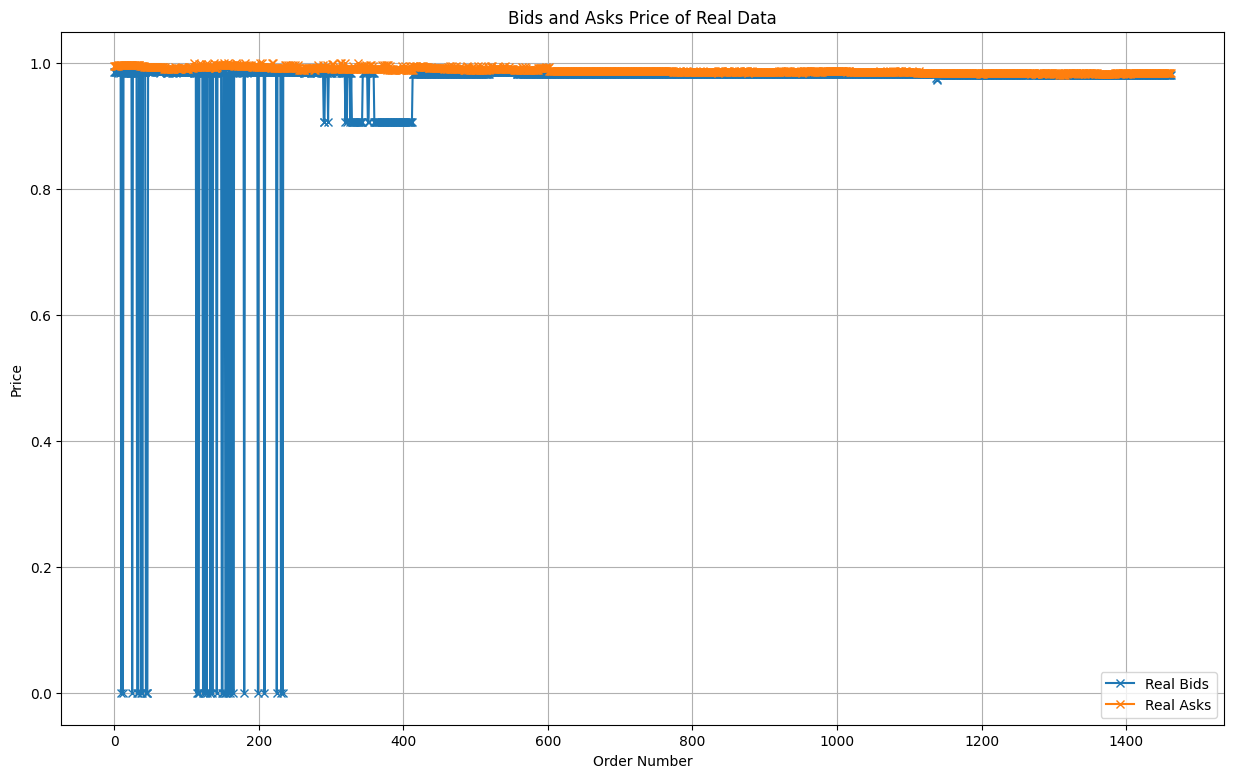

In [ ]:
plt.figure(figsize=(15, 9))


# Create the plot
plt.plot(real_sel[::50,4], marker='x', linestyle='-' ,label='Real Bids')
plt.plot(real_sel[::50,2], marker='x', linestyle='-', label='Real Asks')
# plt.plot(plot_f.iloc[:,4], marker='x', linestyle='--', label='Fake Bids')
# plt.plot(plot_f.iloc[:,2], plot_f.iloc[:,1], marker='x', linestyle='--', label='Fake Asks')

# Add labels and title
plt.xlabel('Order Number')
plt.ylabel('Price')
plt.title('Bids and Asks Price of Real Data')

# Add a legend to distinguish the lines
plt.legend()

# # Adjust the aspect ratio (width / height) as desired
# plt.gca().set_aspect(1.5)  # Increase the number to make x-axis wider, decrease to make y-axis taller

# Display the plot
plt.grid(True)
plt.savefig('realprice.png', bbox_inches='tight', dpi=300)
plt.show()

##Generated Bids And Ask

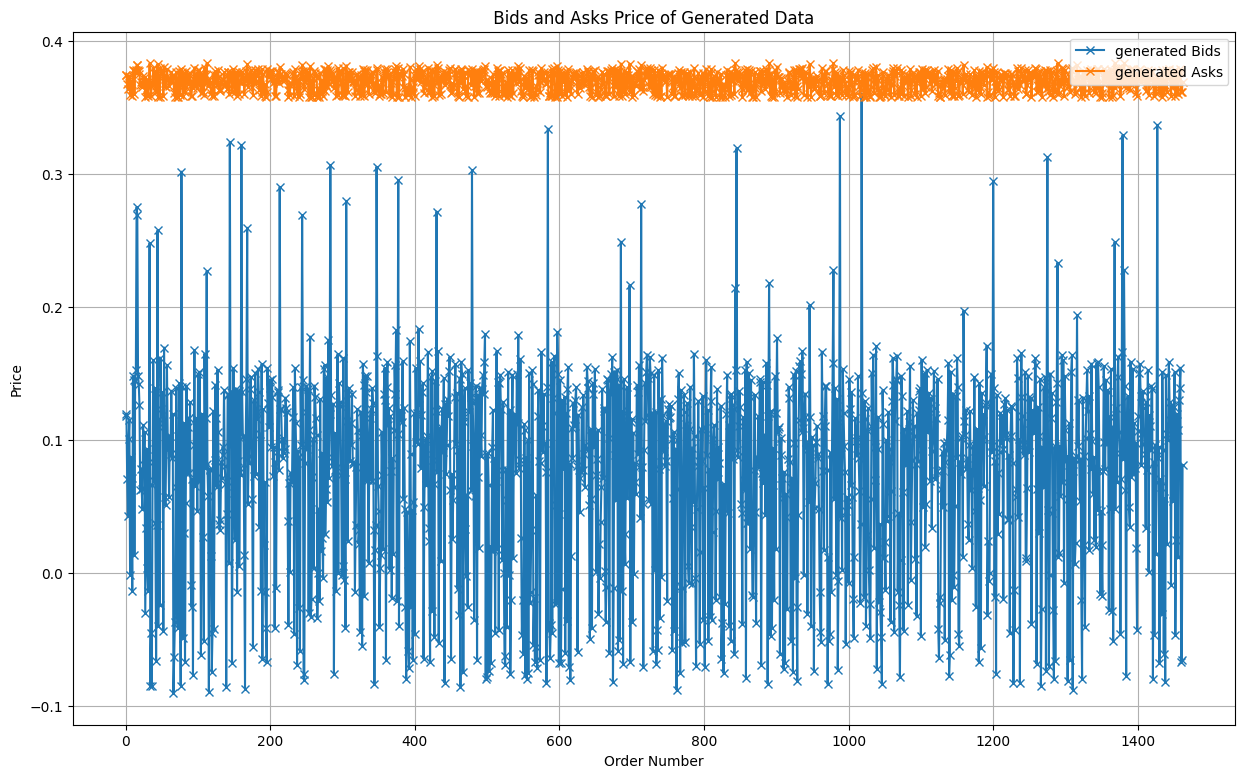

In [ ]:
plt.figure(figsize=(15, 9))


# Create the plot
plt.plot(fake_sel[::50,4], marker='x', linestyle='-' ,label='generated Bids')
plt.plot(fake_sel[::50,2], marker='x', linestyle='-', label='generated Asks')
# plt.plot(plot_f.iloc[:,4], marker='x', linestyle='--', label='Fake Bids')
# plt.plot(plot_f.iloc[:,2], plot_f.iloc[:,1], marker='x', linestyle='--', label='Fake Asks')

# Add labels and title
plt.xlabel('Order Number')
plt.ylabel('Price')
plt.title(' Bids and Asks Price of Generated Data ')

# Add a legend to distinguish the lines
plt.legend(loc='upper right')



# Display the plot
plt.grid(True)
plt.savefig('fakeprice.png', bbox_inches='tight', dpi=300)
plt.show()

## PCA and t-SNE

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
seq_len = 5
idx = np.random.permutation(len(fake_sel))[:sample_size]

real_sample = np.asarray(real_sel)[idx]
synthetic_sample = np.asarray(fake_sel)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

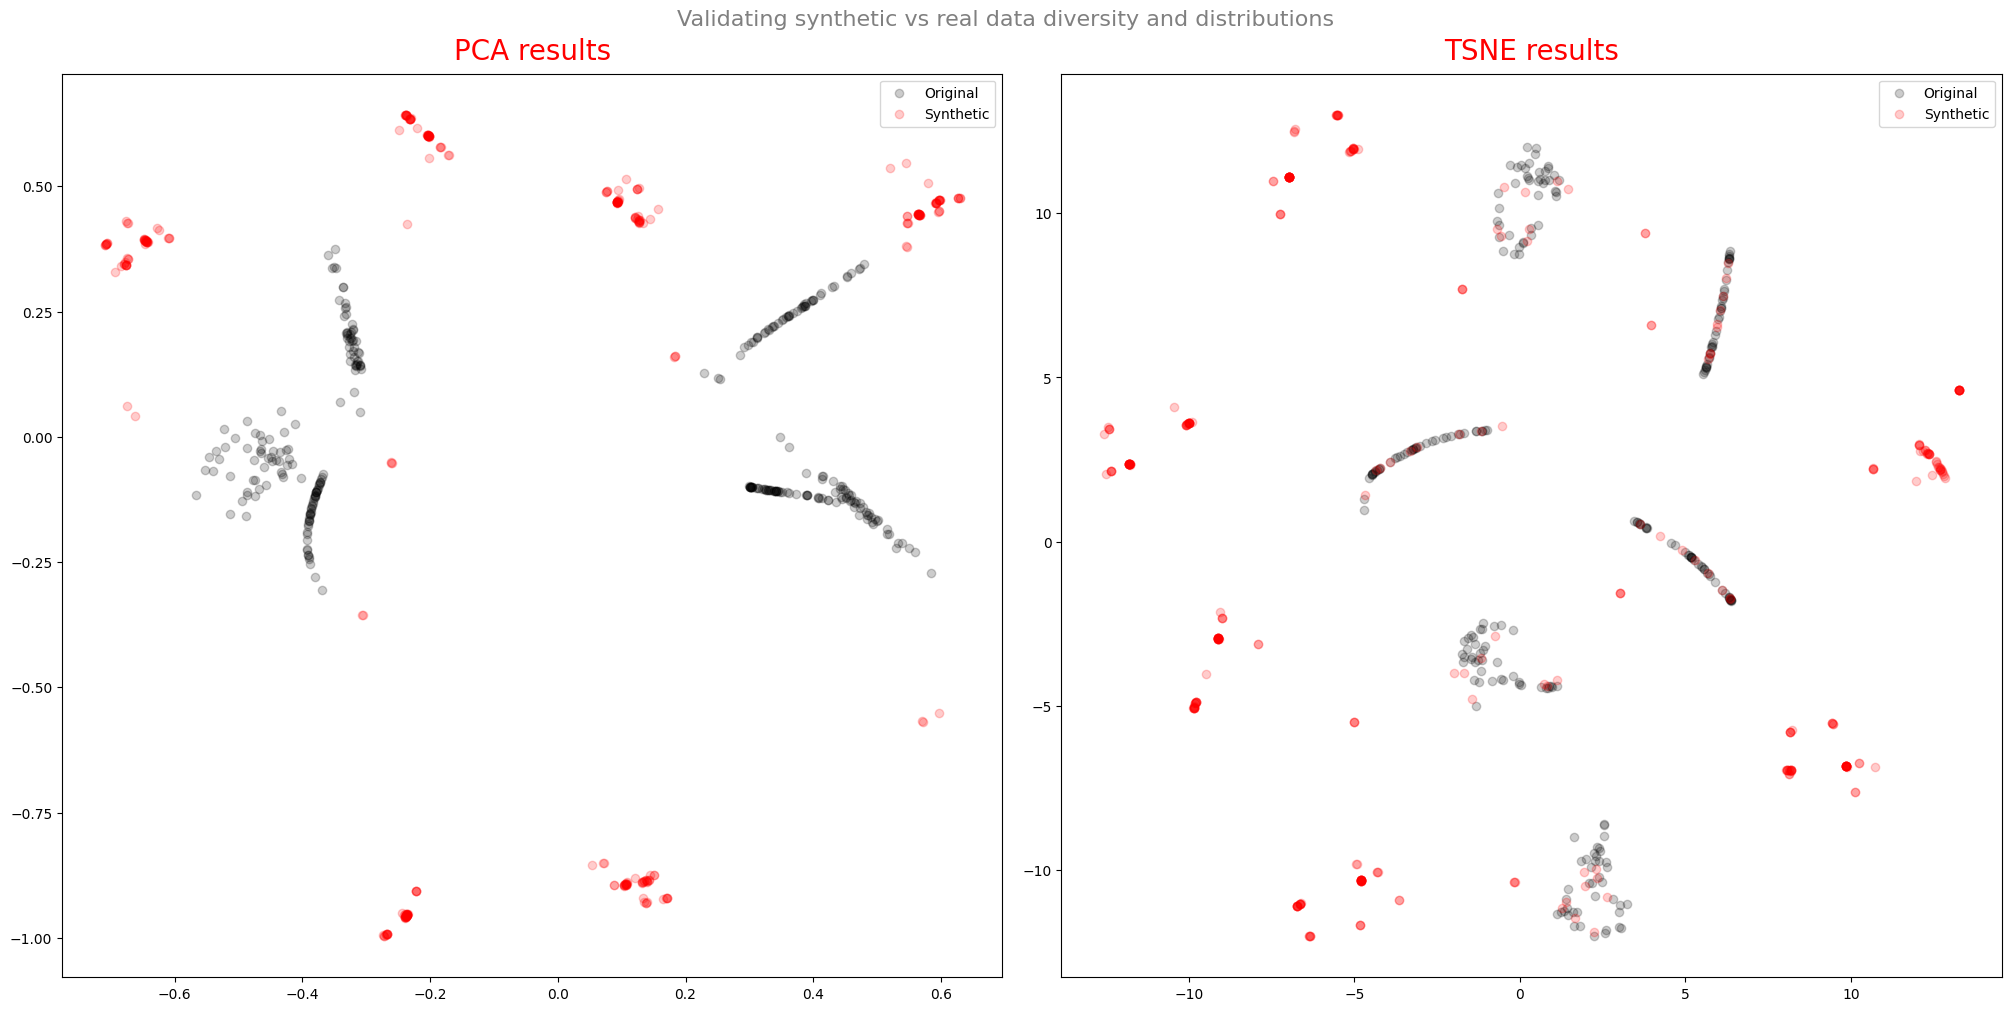

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')
plt.savefig('pca&tsne.png', bbox_inches='tight', dpi=300)

## Pairplot

<ipython-input-82-29b5912e8aa9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_df['Type'] = 'Real'
<ipython-input-82-29b5912e8aa9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['Type'] = 'Generated'


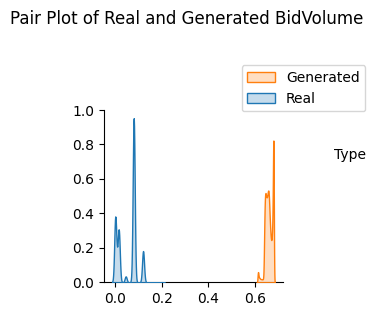

In [ ]:
import pandas as pd
import seaborn as sns

# Assuming real_sel and fake_sel are NumPy arrays or pandas DataFrames with multiple columns
# Example DataFrames
real_sel_df = pd.DataFrame(real_sel, columns=["Time_int", "Mid_Price", "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1"])
fake_sel_df = pd.DataFrame(fake_sel, columns=['Time_int', "Mid_Price", "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1"])

# Create a combined DataFrame with an additional 'Source' column to differentiate real and fake data
name='BidVolume1'
# Create DataFrames with only the 'Time' column
real_df = real_sel_df[[name]]
fake_df = fake_sel_df[[name]]

# Create a combined DataFrame with an additional 'Source' column to differentiate real and fake data
real_df['Type'] = 'Real'
fake_df['Type'] = 'Generated'
combined_time_df = pd.concat([real_df, fake_df])

# Create the pair plot for the 'Time' column only
# Create the pair plot for the 'Time' column only
pair_plot = sns.pairplot(combined_time_df, hue='Type', markers='x', diag_kws={'legend': False})
pair_plot.fig.suptitle('Pair Plot of Real and Generated BidVolume ', y=1.3)
plt.subplots_adjust(top=0.9)
# Create a new legend with custom labels

labels = [ 'Generated','Real']
plt.legend( labels,bbox_to_anchor=(1.5, 1.3), loc='upper right')

# Remove x-axis and y-axis labels
for ax in pair_plot.axes.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.savefig('BidVolume1.png', bbox_inches='tight', dpi=300)

# pair_plot = sns.pairplot(combined_df, hue='Type', markers='x', diag_kws={'legend': False},
#                          corner=True, corner_labels=features)

plt.show()



# Prediction

In [ ]:
import sys
!{sys.executable} -m pip install hdf5storage
!{sys.executable} -m pip install tensorflow

# Import Libraries
import hdf5storage
import pandas as pd
import keras
from keras import layers
import numpy as np
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D,Conv2D,MaxPooling2D,LeakyReLU,LSTM,Dense,Reshape,Flatten
from keras.models import Model,Sequential
from sklearn.metrics import classification_report, accuracy_score,mean_squared_error,precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit

## real data

0.13778300339057203
0.8008722519960626
0.061344744613365414


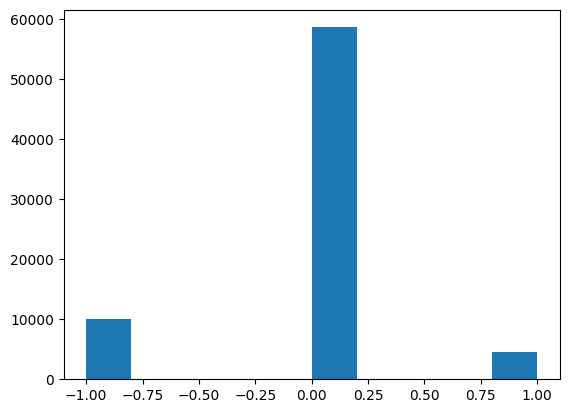

In [ ]:
def future_avg_label(df, mid_price_col, k, alpha):
    """
    Compare the future average of a mid-price column in a pandas DataFrame to the mid-price column itself,
    and assign a label of 1 or -1 depending on whether the future average is larger than 1 + alpha.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the mid-price column.
    mid_price_col (str): The name of the mid-price column.
    k (int): The size of the future window.
    alpha (float): The threshold parameter for the label.

    Returns:
    A pandas Series containing the labels (-1 or 1).
    """
    # Compute the future average of the mid-price column using a rolling window of size k
    future_avg = df[mid_price_col].rolling(k).mean().shift(-k)

    # Compute the labels based on the future average and the mid-price column
    labels = pd.Series([1 if p >= 1 + alpha else -1 if p <= 1 - alpha else 0 for p in (future_avg / df[mid_price_col])])


    return labels
real_sel_df = pd.DataFrame(real_sel.numpy(), columns=["Time_int", "Mid_Price", "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1"])
labels=future_avg_label(real_sel_df,'Mid_Price', 5, 0.00075)
z_score = real_sel_df.assign(Label=labels)
plt.hist(z_score['Label'])

    # Identify the Columns that will be utilized as Inputs to the Regressors
Feature_Matrix =z_score.iloc[10:,2:-1]
# Mid_Price_Series = LOB_Amazon['Labels']
Forecasting_Variable = z_score.iloc[10:,-1]
Forecasting_Variable = z_score.iloc[10:,-1]
print(len(labels[labels<0])/len(labels))
print(len(labels[labels==0])/len(labels))
print(len(labels[labels>0])/len(labels))

The following code are based on the code from Adam Ntakaris:

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D,Conv2D,MaxPooling2D,LeakyReLU,LSTM,Dense,Reshape,Flatten
from keras.models import Model,Sequential
from sklearn.metrics import classification_report, accuracy_score,mean_squared_error,precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error,r2_score

tscv = TimeSeriesSplit()
print(tscv)
print(62*'#')
counter = 0
for train_index,test_index in tscv.split(Feature_Matrix):
# for train_index, test_index in tscv.split(Feature_Matrix):

    counter += 1
    print('Fold %d:' %counter)
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

    X_train, X_test = Feature_Matrix.iloc[train_index,:], Feature_Matrix.iloc[test_index,:]
    Y_train, Y_test = Forecasting_Variable.iloc[train_index], Forecasting_Variable.iloc[test_index]
    print(62*'-')







    # Prepare CNN data - 3D Inputs of the format [samples, lookback period, features]
    #----------------------------------------------------------------------
    # Train Set
    #----------------------------------------------------------------------
    X_train_to_Numpy = pd.DataFrame(X_train).to_numpy()
    Y_train_to_Numpy = pd.DataFrame(Y_train).to_numpy()

    look_back = 10
    x_train_append_matrix = []
    y_train_append_matrix = []

    for i in range(len(X_train)-look_back):
        feat_current_train = X_train_to_Numpy[i:i+look_back, :]
        label_current_train = Y_train_to_Numpy[i+look_back]
        x_train_append_matrix.append(feat_current_train)
        y_train_append_matrix.append(label_current_train)

    X_train_numpy = np.array(x_train_append_matrix)
    Y_train_numpy = np.array(y_train_append_matrix)

    #----------------------------------------------------------------------
    # Test Set
    #----------------------------------------------------------------------
    Y_test = Y_test.values.reshape(-1,1)

    X_test_to_Numpy = pd.DataFrame(X_test).to_numpy()
    Y_test_to_Numpy = pd.DataFrame(Y_test).to_numpy()


    look_back = 10
    x_test_append_matrix = []
    y_test_append_matrix = []

    for i in range(len(X_test)-look_back):
        feat_current_test = X_test_to_Numpy[i:i+look_back, :]
        label_current_test = Y_test_to_Numpy[i+look_back]
        x_test_append_matrix.append(feat_current_test)
        y_test_append_matrix.append(label_current_test)

    X_test_numpy = np.array(x_test_append_matrix)
    Y_test_numpy = np.array(y_test_append_matrix)


    #--------------------------------------------------------------------
   #                           CNN Model
   #--------------------------------------------------------------
    print('**********************  CNN  ****************************')
    model_CNN = Sequential()
    model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back,X_train_numpy.shape[2])))
    model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model_CNN.add(MaxPooling1D(pool_size=2))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(100, activation='relu'))

    model_CNN.add(Dense(1, activation='linear'))
    model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    history=model_CNN.fit(X_train_numpy, Y_train_numpy, epochs=100, batch_size=128, verbose=2)


    #--------------------------------------------------------------------
    #                           Result report
    #--------------------------------------------------------------------


    # Yt= np.argmax(model.predict(X_test_numpy),axis=1)
    Yt_CNN = np.argmax(model_CNN.predict(X_test_numpy),axis=1)



    r_squared = r2_score(Y_test_numpy,  Yt_CNN)
    mae = mean_absolute_error(Y_test_numpy,  Yt_CNN)
    mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
    precision_CNN = precision_score(Y_test_numpy, Yt_CNN,average='weighted')
    recall_CNN = recall_score(Y_test_numpy, Yt_CNN,average='weighted')
    F1_CNN=2*(precision_CNN*recall_CNN)/(precision_CNN+recall_CNN)
    testScore_CNN = mean_squared_error(Y_test_numpy, Yt_CNN)




# Print the results
    # Print the progress
    print(f"Epoch {epoch}/{epochs} [r_squared: {r_squared}] [MAE: {mae}][MRLE:{mrle}]")

    print('testScore_CNN:', testScore_CNN)
    print('precision_CNN:', precision_CNN)
    print('recall_CNN:', recall_CNN)
    print('F1_CNN:', F1_CNN)


    print(62*'#')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
##############################################################
Fold 1:
TRAIN: 12189 TEST: 12189
--------------------------------------------------------------
**********************  CNN  ****************************
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


96/96 - 3s - loss: -2.6731e-08 - accuracy: 0.4380 - 3s/epoch - 28ms/step
Epoch 2/100
96/96 - 1s - loss: -2.6731e-08 - accuracy: 0.4380 - 898ms/epoch - 9ms/step
Epoch 3/100
96/96 - 1s - loss: -2.6731e-08 - accuracy: 0.4380 - 695ms/epoch - 7ms/step
Epoch 4/100
96/96 - 1s - loss: -2.6731e-08 - accuracy: 0.4380 - 646ms/epoch - 7ms/step
Epoch 5/100
96/96 - 1s - loss: -2.6731e-08 - accuracy: 0.4380 - 821ms/epoch - 9ms/step
Epoch 6/100
96/96 - 1s - loss: -2.6731e-08 - accuracy: 0.4380 - 971ms/epoch - 10ms/step
Epoch 7/100
96/96 - 1s - loss: -2.6731e-08 - accuracy: 0.4380 - 937ms/epoch - 10ms/step
Epoch 8/100
96/96 - 1s - loss: -2.6731e-08 - accuracy: 0.4380 - 770ms/epoch - 8ms/step
Epoch 9/100
96/96 - 1s - loss: -2.6731e-08 - accuracy: 0.4380 - 618ms/epoch - 6ms/step
Epoch 10/100
96/96 - 1s - loss: -2.6731e-08 - accuracy: 0.4380 - 632ms/epoch - 7ms/step
Epoch 11/100
96/96 - 1s - loss: -2.6731e-08 - accuracy: 0.4380 - 644ms/epoch - 7ms/step
Epoch 12/100
96/96 - 1s - loss: -2.6731e-08 - accurac

<ipython-input-136-8cba70bd9392>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.017382902183796567] [MAE: 0.3867312587240332][MRLE:inf]
testScore_CNN: 0.3867312587240332
precision_CNN: 0.37609854902620876
recall_CNN: 0.6132687412759669
F1_CNN: 0.46625653792652655
##############################################################
Fold 2:
TRAIN: 24378 TEST: 12189
--------------------------------------------------------------
**********************  CNN  ****************************
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


191/191 - 2s - loss: -1.8213e-08 - accuracy: 0.5257 - 2s/epoch - 12ms/step
Epoch 2/100
191/191 - 1s - loss: -1.8213e-08 - accuracy: 0.5257 - 1s/epoch - 6ms/step
Epoch 3/100
191/191 - 1s - loss: -1.8213e-08 - accuracy: 0.5257 - 1s/epoch - 6ms/step
Epoch 4/100
191/191 - 1s - loss: -1.8213e-08 - accuracy: 0.5257 - 1s/epoch - 6ms/step
Epoch 5/100
191/191 - 1s - loss: -1.8213e-08 - accuracy: 0.5257 - 1s/epoch - 6ms/step
Epoch 6/100
191/191 - 1s - loss: -1.8213e-08 - accuracy: 0.5257 - 1s/epoch - 7ms/step
Epoch 7/100
191/191 - 2s - loss: -1.8213e-08 - accuracy: 0.5257 - 2s/epoch - 9ms/step
Epoch 8/100
191/191 - 2s - loss: -1.8213e-08 - accuracy: 0.5257 - 2s/epoch - 9ms/step
Epoch 9/100
191/191 - 1s - loss: -1.8213e-08 - accuracy: 0.5257 - 1s/epoch - 6ms/step
Epoch 10/100
191/191 - 1s - loss: -1.8213e-08 - accuracy: 0.5257 - 1s/epoch - 6ms/step
Epoch 11/100
191/191 - 1s - loss: -1.8213e-08 - accuracy: 0.5257 - 1s/epoch - 6ms/step
Epoch 12/100
191/191 - 1s - loss: -1.8213e-08 - accuracy: 0.525

<ipython-input-136-8cba70bd9392>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.013757145137594406] [MAE: 0.11782576566220544][MRLE:inf]
testScore_CNN: 0.11782576566220544
precision_CNN: 0.778231379729474
recall_CNN: 0.8821742343377945
F1_CNN: 0.8269493498865998
##############################################################
Fold 3:
TRAIN: 36567 TEST: 12189
--------------------------------------------------------------
**********************  CNN  ****************************
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


286/286 - 3s - loss: -1.3735e-08 - accuracy: 0.6445 - 3s/epoch - 10ms/step
Epoch 2/100
286/286 - 2s - loss: -1.3735e-08 - accuracy: 0.6445 - 2s/epoch - 7ms/step
Epoch 3/100
286/286 - 3s - loss: -1.3735e-08 - accuracy: 0.6445 - 3s/epoch - 9ms/step
Epoch 4/100
286/286 - 2s - loss: -1.3735e-08 - accuracy: 0.6445 - 2s/epoch - 6ms/step
Epoch 5/100
286/286 - 2s - loss: -1.3735e-08 - accuracy: 0.6445 - 2s/epoch - 6ms/step
Epoch 6/100
286/286 - 2s - loss: -1.3735e-08 - accuracy: 0.6445 - 2s/epoch - 6ms/step
Epoch 7/100
286/286 - 2s - loss: -1.3735e-08 - accuracy: 0.6445 - 2s/epoch - 6ms/step
Epoch 8/100
286/286 - 2s - loss: -1.3735e-08 - accuracy: 0.6445 - 2s/epoch - 6ms/step
Epoch 9/100
286/286 - 2s - loss: -1.3735e-08 - accuracy: 0.6445 - 2s/epoch - 9ms/step
Epoch 10/100
286/286 - 2s - loss: -1.3735e-08 - accuracy: 0.6445 - 2s/epoch - 8ms/step
Epoch 11/100
286/286 - 2s - loss: -1.3735e-08 - accuracy: 0.6445 - 2s/epoch - 6ms/step
Epoch 12/100
286/286 - 2s - loss: -1.3735e-08 - accuracy: 0.644

<ipython-input-136-8cba70bd9392>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.05707974351091072] [MAE: 0.06708268330733229][MRLE:inf]
testScore_CNN: 0.06708268330733229
precision_CNN: 0.8703347197850473
recall_CNN: 0.9329173166926678
F1_CNN: 0.9005400409720989
##############################################################
Fold 4:
TRAIN: 48756 TEST: 12189
--------------------------------------------------------------
**********************  CNN  ****************************
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


381/381 - 4s - loss: -1.2093e-08 - accuracy: 0.7166 - 4s/epoch - 10ms/step
Epoch 2/100
381/381 - 3s - loss: -1.2093e-08 - accuracy: 0.7166 - 3s/epoch - 8ms/step
Epoch 3/100
381/381 - 2s - loss: -1.2093e-08 - accuracy: 0.7166 - 2s/epoch - 6ms/step
Epoch 4/100
381/381 - 2s - loss: -1.2093e-08 - accuracy: 0.7166 - 2s/epoch - 7ms/step
Epoch 5/100
381/381 - 2s - loss: -1.2093e-08 - accuracy: 0.7166 - 2s/epoch - 6ms/step
Epoch 6/100
381/381 - 3s - loss: -1.2093e-08 - accuracy: 0.7166 - 3s/epoch - 8ms/step
Epoch 7/100
381/381 - 3s - loss: -1.2093e-08 - accuracy: 0.7166 - 3s/epoch - 8ms/step
Epoch 8/100
381/381 - 2s - loss: -1.2093e-08 - accuracy: 0.7166 - 2s/epoch - 6ms/step
Epoch 9/100
381/381 - 2s - loss: -1.2093e-08 - accuracy: 0.7166 - 2s/epoch - 6ms/step
Epoch 10/100
381/381 - 2s - loss: -1.2093e-08 - accuracy: 0.7166 - 2s/epoch - 6ms/step
Epoch 11/100
381/381 - 3s - loss: -1.2093e-08 - accuracy: 0.7166 - 3s/epoch - 8ms/step
Epoch 12/100
381/381 - 3s - loss: -1.2093e-08 - accuracy: 0.716

<ipython-input-136-8cba70bd9392>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.03647654001727818] [MAE: 0.04885458576237786][MRLE:inf]
testScore_CNN: 0.04885458576237786
precision_CNN: 0.9046775990252577
recall_CNN: 0.9511454142376221
F1_CNN: 0.9273297545367685
##############################################################
Fold 5:
TRAIN: 60945 TEST: 12189
--------------------------------------------------------------
**********************  CNN  ****************************
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


477/477 - 5s - loss: -1.0662e-08 - accuracy: 0.7636 - 5s/epoch - 10ms/step
Epoch 2/100
477/477 - 3s - loss: -1.0662e-08 - accuracy: 0.7636 - 3s/epoch - 7ms/step
Epoch 3/100
477/477 - 3s - loss: -1.0662e-08 - accuracy: 0.7636 - 3s/epoch - 6ms/step
Epoch 4/100
477/477 - 3s - loss: -1.0662e-08 - accuracy: 0.7636 - 3s/epoch - 6ms/step
Epoch 5/100
477/477 - 4s - loss: -1.0662e-08 - accuracy: 0.7636 - 4s/epoch - 9ms/step
Epoch 6/100
477/477 - 3s - loss: -1.0662e-08 - accuracy: 0.7636 - 3s/epoch - 7ms/step
Epoch 7/100
477/477 - 3s - loss: -1.0662e-08 - accuracy: 0.7636 - 3s/epoch - 6ms/step
Epoch 8/100
477/477 - 3s - loss: -1.0662e-08 - accuracy: 0.7636 - 3s/epoch - 6ms/step
Epoch 9/100
477/477 - 4s - loss: -1.0662e-08 - accuracy: 0.7636 - 4s/epoch - 8ms/step
Epoch 10/100
477/477 - 3s - loss: -1.0662e-08 - accuracy: 0.7636 - 3s/epoch - 6ms/step
Epoch 11/100
477/477 - 3s - loss: -1.0662e-08 - accuracy: 0.7636 - 3s/epoch - 6ms/step
Epoch 12/100
477/477 - 3s - loss: -1.0662e-08 - accuracy: 0.763

<ipython-input-136-8cba70bd9392>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))


Epoch 4999/5000 [r_squared: -0.010311164339160017] [MAE: 0.012398390672469005][MRLE:inf]
testScore_CNN: 0.012398390672469005
precision_CNN: 0.9753569387463292
recall_CNN: 0.987601609327531
F1_CNN: 0.9814410837354107
##############################################################


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## fake data

0.0465930219840315
0.8004757738160341
0.1529312041999344


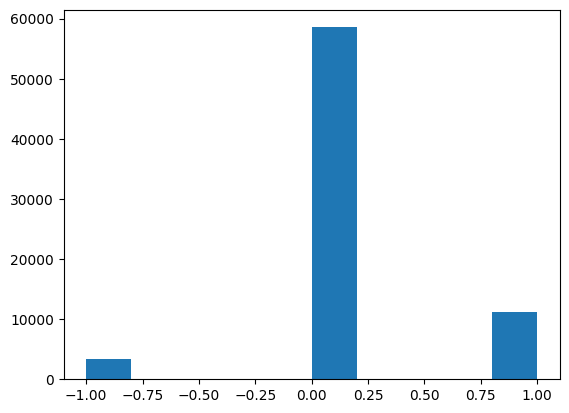

In [ ]:
def future_avg_label(df, mid_price_col, k, alpha):
    """
    Compare the future average of a mid-price column in a pandas DataFrame to the mid-price column itself,
    and assign a label of 1 or -1 depending on whether the future average is larger than 1 + alpha.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the mid-price column.
    mid_price_col (str): The name of the mid-price column.
    k (int): The size of the future window.
    alpha (float): The threshold parameter for the label.

    Returns:
    A pandas Series containing the labels (-1 or 1).
    """
    # Compute the future average of the mid-price column using a rolling window of size k
    future_avg = df[mid_price_col].rolling(k).mean().shift(-k)

    # Compute the labels based on the future average and the mid-price column
    labels = pd.Series([1 if p >= 1 + alpha else -1 if p <= 1 - alpha else 0 for p in (future_avg / df[mid_price_col])])


    return labels
fake_sel_df = pd.DataFrame(fake_sel.numpy(), columns=["Time_int", "Mid_Price", "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1"])
labels=future_avg_label(fake_sel_df,'Mid_Price', 5, 0.123)
z_score_f = fake_sel_df.assign(Label=labels)
plt.hist(z_score_f['Label'])

    # Identify the Columns that will be utilized as Inputs to the Regressors
Feature_Matrix_f =z_score_f.iloc[10:,2:-1]
# Mid_Price_Series = LOB_Amazon['Labels']
Forecasting_Variable_f = z_score_f.iloc[10:,-1]
print(len(labels[labels<0])/len(labels))
print(len(labels[labels==0])/len(labels))
print(len(labels[labels>0])/len(labels))

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D,Conv2D,MaxPooling2D,LeakyReLU,LSTM,Dense,Reshape,Flatten
from keras.models import Model,Sequential
from sklearn.metrics import classification_report, accuracy_score,mean_squared_error,precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error,r2_score

tscv = TimeSeriesSplit()
print(tscv)
print(62*'#')
counter = 0
for train_index,test_index in tscv.split(Feature_Matrix):
# for train_index, test_index in tscv.split(Feature_Matrix):

    counter += 1
    print('Fold %d:' %counter)
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

    X_train, X_test = Feature_Matrix_f.iloc[train_index,:], Feature_Matrix_f.iloc[test_index,:]
    Y_train, Y_test = Forecasting_Variable_f.iloc[train_index], Forecasting_Variable_f.iloc[test_index]
    print(62*'-')







    # Prepare CNN data - 3D Inputs of the format [samples, lookback period, features]
    #----------------------------------------------------------------------
    # Train Set
    #----------------------------------------------------------------------
    X_train_to_Numpy = pd.DataFrame(X_train).to_numpy()
    Y_train_to_Numpy = pd.DataFrame(Y_train).to_numpy()

    look_back = 10
    x_train_append_matrix = []
    y_train_append_matrix = []

    for i in range(len(X_train)-look_back):
        feat_current_train = X_train_to_Numpy[i:i+look_back, :]
        label_current_train = Y_train_to_Numpy[i+look_back]
        x_train_append_matrix.append(feat_current_train)
        y_train_append_matrix.append(label_current_train)

    X_train_numpy = np.array(x_train_append_matrix)
    Y_train_numpy = np.array(y_train_append_matrix)

    #----------------------------------------------------------------------
    # Test Set
    #----------------------------------------------------------------------
    Y_test = Y_test.values.reshape(-1,1)

    X_test_to_Numpy = pd.DataFrame(X_test).to_numpy()
    Y_test_to_Numpy = pd.DataFrame(Y_test).to_numpy()


    look_back = 10
    x_test_append_matrix = []
    y_test_append_matrix = []

    for i in range(len(X_test)-look_back):
        feat_current_test = X_test_to_Numpy[i:i+look_back, :]
        label_current_test = Y_test_to_Numpy[i+look_back]
        x_test_append_matrix.append(feat_current_test)
        y_test_append_matrix.append(label_current_test)

    X_test_numpy = np.array(x_test_append_matrix)
    Y_test_numpy = np.array(y_test_append_matrix)
     #----about y--------------
#     Y_train_numpy = keras.utils.to_categorical(Y_train_numpy, 3)
#     Y_test_numpy = keras.utils.to_categorical(Y_test_numpy, 3)


    #--------------------------------------------------------------------
   #                           CNN Model
   #--------------------------------------------------------------
    print('**********************  CNN  ****************************')
    model_CNN = Sequential()
    model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back,X_train_numpy.shape[2])))
    model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model_CNN.add(MaxPooling1D(pool_size=2))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(100, activation='relu'))

    model_CNN.add(Dense(1, activation='linear'))
    model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    history=model_CNN.fit(X_train_numpy, Y_train_numpy, epochs=100, batch_size=128, verbose=2)


    #--------------------------------------------------------------------
    #                           Result report
    #--------------------------------------------------------------------


    # Yt= np.argmax(model.predict(X_test_numpy),axis=1)
    Yt_CNN = np.argmax(model_CNN.predict(X_test_numpy),axis=1)



    r_squared = r2_score(Y_test_numpy,  Yt_CNN)
    mae = mean_absolute_error(Y_test_numpy,  Yt_CNN)
    mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
    precision_CNN = precision_score(Y_test_numpy, Yt_CNN,average='weighted')
    recall_CNN = recall_score(Y_test_numpy, Yt_CNN,average='weighted')
    F1_CNN=2*(precision_CNN*recall_CNN)/(precision_CNN+recall_CNN)
    testScore_CNN = mean_squared_error(Y_test_numpy, Yt_CNN)




# Print the results
    # Print the progress
    print(f"Epoch {epoch}/{epochs} [r_squared: {r_squared}] [MAE: {mae}][MRLE:{mrle}]")

    print('testScore_CNN:', testScore_CNN)
    print('precision_CNN:', precision_CNN)
    print('recall_CNN:', recall_CNN)
    print('F1_CNN:', F1_CNN)


    print(62*'#')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
##############################################################
Fold 1:
TRAIN: 12189 TEST: 12189
--------------------------------------------------------------
**********************  CNN  ****************************
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


96/96 - 2s - loss: 1.2881e-08 - accuracy: 0.7931 - 2s/epoch - 17ms/step
Epoch 2/100
96/96 - 1s - loss: 1.2881e-08 - accuracy: 0.7931 - 621ms/epoch - 6ms/step
Epoch 3/100
96/96 - 1s - loss: 1.2881e-08 - accuracy: 0.7931 - 640ms/epoch - 7ms/step
Epoch 4/100
96/96 - 1s - loss: 1.2881e-08 - accuracy: 0.7931 - 639ms/epoch - 7ms/step
Epoch 5/100
96/96 - 1s - loss: 1.2881e-08 - accuracy: 0.7931 - 641ms/epoch - 7ms/step
Epoch 6/100
96/96 - 1s - loss: 1.2881e-08 - accuracy: 0.7931 - 655ms/epoch - 7ms/step
Epoch 7/100
96/96 - 1s - loss: 1.2881e-08 - accuracy: 0.7931 - 656ms/epoch - 7ms/step
Epoch 8/100
96/96 - 1s - loss: 1.2881e-08 - accuracy: 0.7931 - 621ms/epoch - 6ms/step
Epoch 9/100
96/96 - 1s - loss: 1.2881e-08 - accuracy: 0.7931 - 725ms/epoch - 8ms/step
Epoch 10/100
96/96 - 1s - loss: 1.2881e-08 - accuracy: 0.7931 - 966ms/epoch - 10ms/step
Epoch 11/100
96/96 - 1s - loss: 1.2881e-08 - accuracy: 0.7931 - 972ms/epoch - 10ms/step
Epoch 12/100
96/96 - 1s - loss: 1.2881e-08 - accuracy: 0.7931 - 

<ipython-input-135-8adefcd44119>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.06239261980376254] [MAE: 0.1991132276870022][MRLE:inf]
testScore_CNN: 0.1991132276870022
precision_CNN: 0.6414196220659315
recall_CNN: 0.8008867723129978
F1_CNN: 0.7123375349601951
##############################################################
Fold 2:
TRAIN: 24378 TEST: 12189
--------------------------------------------------------------
**********************  CNN  ****************************
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


191/191 - 3s - loss: 1.2881e-08 - accuracy: 0.7971 - 3s/epoch - 18ms/step
Epoch 2/100
191/191 - 1s - loss: 1.2881e-08 - accuracy: 0.7971 - 1s/epoch - 7ms/step
Epoch 3/100
191/191 - 1s - loss: 1.2881e-08 - accuracy: 0.7971 - 1s/epoch - 7ms/step
Epoch 4/100
191/191 - 1s - loss: 1.2881e-08 - accuracy: 0.7971 - 1s/epoch - 7ms/step
Epoch 5/100
191/191 - 1s - loss: 1.2881e-08 - accuracy: 0.7971 - 1s/epoch - 7ms/step
Epoch 6/100
191/191 - 1s - loss: 1.2881e-08 - accuracy: 0.7971 - 1s/epoch - 7ms/step
Epoch 7/100
191/191 - 1s - loss: 1.2881e-08 - accuracy: 0.7971 - 1s/epoch - 7ms/step
Epoch 8/100
191/191 - 2s - loss: 1.2881e-08 - accuracy: 0.7971 - 2s/epoch - 8ms/step
Epoch 9/100
191/191 - 2s - loss: 1.2881e-08 - accuracy: 0.7971 - 2s/epoch - 10ms/step
Epoch 10/100
191/191 - 1s - loss: 1.2881e-08 - accuracy: 0.7971 - 1s/epoch - 6ms/step
Epoch 11/100
191/191 - 1s - loss: 1.2881e-08 - accuracy: 0.7971 - 1s/epoch - 7ms/step
Epoch 12/100
191/191 - 1s - loss: 1.2881e-08 - accuracy: 0.7971 - 1s/epoc

<ipython-input-135-8adefcd44119>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.05593822091244327] [MAE: 0.2010838328269973][MRLE:inf]
testScore_CNN: 0.2010838328269973
precision_CNN: 0.6382670421704012
recall_CNN: 0.7989161671730027
F1_CNN: 0.7096128811532535
##############################################################
Fold 3:
TRAIN: 36567 TEST: 12189
--------------------------------------------------------------
**********************  CNN  ****************************
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


286/286 - 3s - loss: 1.2685e-08 - accuracy: 0.7976 - 3s/epoch - 10ms/step
Epoch 2/100
286/286 - 2s - loss: 1.2685e-08 - accuracy: 0.7976 - 2s/epoch - 7ms/step
Epoch 3/100
286/286 - 2s - loss: 1.2685e-08 - accuracy: 0.7976 - 2s/epoch - 8ms/step
Epoch 4/100
286/286 - 2s - loss: 1.2685e-08 - accuracy: 0.7976 - 2s/epoch - 8ms/step
Epoch 5/100
286/286 - 2s - loss: 1.2685e-08 - accuracy: 0.7976 - 2s/epoch - 7ms/step
Epoch 6/100
286/286 - 2s - loss: 1.2685e-08 - accuracy: 0.7976 - 2s/epoch - 6ms/step
Epoch 7/100
286/286 - 2s - loss: 1.2685e-08 - accuracy: 0.7976 - 2s/epoch - 7ms/step
Epoch 8/100
286/286 - 2s - loss: 1.2685e-08 - accuracy: 0.7976 - 2s/epoch - 6ms/step
Epoch 9/100
286/286 - 2s - loss: 1.2685e-08 - accuracy: 0.7976 - 2s/epoch - 7ms/step
Epoch 10/100
286/286 - 3s - loss: 1.2685e-08 - accuracy: 0.7976 - 3s/epoch - 9ms/step
Epoch 11/100
286/286 - 2s - loss: 1.2685e-08 - accuracy: 0.7976 - 2s/epoch - 7ms/step
Epoch 12/100
286/286 - 2s - loss: 1.2685e-08 - accuracy: 0.7976 - 2s/epoch

<ipython-input-135-8adefcd44119>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.06383141813407711] [MAE: 0.19845635930700387][MRLE:inf]
testScore_CNN: 0.19845635930700387
precision_CNN: 0.6424722079353828
recall_CNN: 0.8015436406929961
F1_CNN: 0.7132463443275172
##############################################################
Fold 4:
TRAIN: 48756 TEST: 12189
--------------------------------------------------------------
**********************  CNN  ****************************
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


381/381 - 4s - loss: 1.2768e-08 - accuracy: 0.7986 - 4s/epoch - 9ms/step
Epoch 2/100
381/381 - 3s - loss: 1.2768e-08 - accuracy: 0.7986 - 3s/epoch - 9ms/step
Epoch 3/100
381/381 - 3s - loss: 1.2768e-08 - accuracy: 0.7986 - 3s/epoch - 7ms/step
Epoch 4/100
381/381 - 2s - loss: 1.2768e-08 - accuracy: 0.7986 - 2s/epoch - 7ms/step
Epoch 5/100
381/381 - 2s - loss: 1.2768e-08 - accuracy: 0.7986 - 2s/epoch - 7ms/step
Epoch 6/100
381/381 - 2s - loss: 1.2768e-08 - accuracy: 0.7986 - 2s/epoch - 7ms/step
Epoch 7/100
381/381 - 3s - loss: 1.2768e-08 - accuracy: 0.7986 - 3s/epoch - 9ms/step
Epoch 8/100
381/381 - 2s - loss: 1.2768e-08 - accuracy: 0.7986 - 2s/epoch - 6ms/step
Epoch 9/100
381/381 - 3s - loss: 1.2768e-08 - accuracy: 0.7986 - 3s/epoch - 7ms/step
Epoch 10/100
381/381 - 3s - loss: 1.2768e-08 - accuracy: 0.7986 - 3s/epoch - 8ms/step
Epoch 11/100
381/381 - 4s - loss: 1.2768e-08 - accuracy: 0.7986 - 4s/epoch - 11ms/step
Epoch 12/100
381/381 - 3s - loss: 1.2768e-08 - accuracy: 0.7986 - 3s/epoch

<ipython-input-135-8adefcd44119>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.06094166860741046] [MAE: 0.19410460628951473][MRLE:inf]
testScore_CNN: 0.19410460628951473
precision_CNN: 0.649467385603778
recall_CNN: 0.8058953937104852
F1_CNN: 0.719274646655307
##############################################################
Fold 5:
TRAIN: 60945 TEST: 12189
--------------------------------------------------------------
**********************  CNN  ****************************
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


477/477 - 4s - loss: 1.2730e-08 - accuracy: 0.8000 - 4s/epoch - 9ms/step
Epoch 2/100
477/477 - 4s - loss: 1.2730e-08 - accuracy: 0.8000 - 4s/epoch - 8ms/step
Epoch 3/100
477/477 - 4s - loss: 1.2730e-08 - accuracy: 0.8000 - 4s/epoch - 8ms/step
Epoch 4/100
477/477 - 3s - loss: 1.2730e-08 - accuracy: 0.8000 - 3s/epoch - 7ms/step
Epoch 5/100
477/477 - 3s - loss: 1.2730e-08 - accuracy: 0.8000 - 3s/epoch - 7ms/step
Epoch 6/100
477/477 - 4s - loss: 1.2730e-08 - accuracy: 0.8000 - 4s/epoch - 9ms/step
Epoch 7/100
477/477 - 3s - loss: 1.2730e-08 - accuracy: 0.8000 - 3s/epoch - 7ms/step
Epoch 8/100
477/477 - 3s - loss: 1.2730e-08 - accuracy: 0.8000 - 3s/epoch - 7ms/step
Epoch 9/100
477/477 - 3s - loss: 1.2730e-08 - accuracy: 0.8000 - 3s/epoch - 7ms/step
Epoch 10/100
477/477 - 4s - loss: 1.2730e-08 - accuracy: 0.8000 - 4s/epoch - 9ms/step
Epoch 11/100
477/477 - 3s - loss: 1.2730e-08 - accuracy: 0.8000 - 3s/epoch - 6ms/step
Epoch 12/100
477/477 - 3s - loss: 1.2730e-08 - accuracy: 0.8000 - 3s/epoch 

<ipython-input-135-8adefcd44119>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))


Epoch 4999/5000 [r_squared: -0.05819774546790768] [MAE: 0.1977173823795057][MRLE:inf]
testScore_CNN: 0.1977173823795057
precision_CNN: 0.6436573985359922
recall_CNN: 0.8022826176204942
F1_CNN: 0.7142691076783462
##############################################################


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
